# Context Tree Weighting Examples

In [1]:
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

import json
from src.taxonomy.category_mapping import CategoryMapper
from src.exceptions.exceptions import NoCategoryMatched, NotValidTypes

working dir /home/tales/dev/master/mdc_analysis


This notebook walks through the usage of the context tree weighting implementation in `ctw.py`.

## 1. Generate Data
First, we'll generate some data from a tree source. 
<br>
We'll do this using a somewhat unsightly parameter dictionary where each key represents a context and each value is a specification of parameters for the next samples. 
<br>
The parameter dictionary defined below generates <b>two sequences</b>, 
<br>
$X_n\in\{0,1,2\}$ 
<br>
and
<br>
$Y_n\in\{0,1\}$ 
<br>
for $n=1,\dots,N$. The depth of the tree is chosen to be $D=2$, meaning that for each *context* $s=(x_{n-1},x_{n-2},y_{n-1},y_{n-2})$ we have the two parameter vectors $\theta_x = [p_{x0},p_{x1},p_{x2}]$ and $\theta_y = [p_{y0},p_{y1}]$ with $p_{xi} \triangleq Pr(x=i)$ and $\sum_i p_{xi}=1$ (and similarly for $y$). This particular set up demonstrates the ability of the CTW class to make predictions of $M$-ary sequences (in this case $M=3$) and to make predictions using side information, $Y_n$. You can make changes to the generating tree source, but note that for ease of building the data generation function, only complete trees are handled (an incomplete tree can be made by setting neighboring leaf nodes to have the same parameters).

In [2]:
[1/3]*3,[1/2]*2

([0.3333333333333333, 0.3333333333333333, 0.3333333333333333], [0.5, 0.5])

In [3]:
[1/3,1/2,1/6],[1/2]*2

([0.3333333333333333, 0.5, 0.16666666666666666], [0.5, 0.5])

In [4]:
[1/6,1/6,2/3],[1/2]*2

([0.16666666666666666, 0.16666666666666666, 0.6666666666666666], [0.5, 0.5])

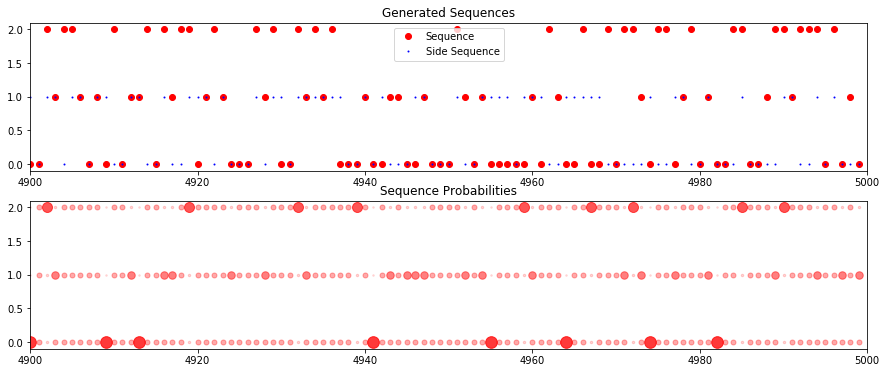

In [5]:
%matplotlib inline
from src.ml.ctw.gendata import gendata, plotprobs

# dictionary of parameters for depth 2 tree with x in {0,1,2} and y in {0,1}
# params['[[x{n-1},x{n-2}],[y{n-1},y{n-2}]]'] = ([p(xn=0),p(xn=1),p(xn=2)],[p(yn=0),p(yn=1)])
params ={
    '[[0,0],[0,0]]':([1/3]*3,[1/2]*2),
    '[[0,0],[0,1]]':([1/3,1/2,1/6],[1/2]*2),
    '[[0,0],[1,0]]':([1/6,1/6,2/3],[1/2]*2),
    '[[0,0],[1,1]]':([1/3]*3,[1/2]*2),
    '[[0,1],[0,0]]':([1/3,1/2,1/6],[1/2]*2),
    '[[0,1],[0,1]]':([7/9,1/9,1/9],[1/2]*2),
    '[[0,1],[1,0]]':([1/3]*3,[1/2]*2),
    '[[0,1],[1,1]]':([1/3]*3,[1/2]*2),
    '[[0,2],[0,0]]':([1/6,1/6,2/3],[1/2]*2),
    '[[0,2],[0,1]]':([1/3,1/2,1/6],[1/2]*2),
    '[[0,2],[1,0]]':([1/3]*3,[1/2]*2),
    '[[0,2],[1,1]]':([1/6,1/6,2/3],[1/2]*2),
    '[[1,0],[0,0]]':([1/3,1/2,1/6],[1/2]*2),
    '[[1,0],[0,1]]':([1/3]*3,[1/2]*2),
    '[[1,0],[1,0]]':([1/3]*3,[1/2]*2),
    '[[1,0],[1,1]]':([1/3]*3,[1/2]*2),
    '[[1,1],[0,0]]':([1/3,1/2,1/6],[1/2]*2),
    '[[1,1],[0,1]]':([1/3]*3,[1/2]*2),
    '[[1,1],[1,0]]':([1/3]*3,[1/2]*2),
    '[[1,1],[1,1]]':([1/3]*3,[1/2]*2),
    '[[1,2],[0,0]]':([1/6,1/6,2/3],[1/2]*2),
    '[[1,2],[0,1]]':([1/3]*3,[1/2]*2),
    '[[1,2],[1,0]]':([1/3]*3,[1/2]*2),
    '[[1,2],[1,1]]':([1/3]*3,[1/2]*2),
    '[[2,0],[0,0]]':([1/3,1/2,1/6],[1/2]*2),
    '[[2,0],[0,1]]':([1/3]*3,[1/2]*2),
    '[[2,0],[1,0]]':([1/3]*3,[1/2]*2),
    '[[2,0],[1,1]]':([1/3]*3,[1/2]*2),
    '[[2,1],[0,0]]':([7/9,1/9,1/9],[1/2]*2),
    '[[2,1],[0,1]]':([1/3,1/2,1/6],[1/2]*2),
    '[[2,1],[1,0]]':([1/3]*3,[1/2]*2),
    '[[2,1],[1,1]]':([1/3]*3,[1/2]*2),
    '[[2,2],[0,0]]':([1/3,1/2,1/6],[1/2]*2),
    '[[2,2],[0,1]]':([1/3]*3,[1/2]*2),
    '[[2,2],[1,0]]':([7/9,1/9,1/9],[1/2]*2),
    '[[2,2],[1,1]]':([7/9,1/9,1/9],[1/2]*2),
}

x,y = gendata(N=5000,params=params,plot_samples=100)

For viewing purposes, we are only showing the last 100 samples of the sequences. The bottom plot shows the true next sample probabilities of $X_n$ (i.e. $\theta_x$ at time $n$) because our CTW will be output a probability assignment for the next sample $X_n$ given the past of the sequence and the side information. In these plots, larger circles represent higher probabilities.

## 2. Sequential Probability Assignment with Depth-2 CTW (w/ side info)
First we'll produce sequential probability assignments using a depth-2 context tree with access to side information. A couple notes on use of the `CTW` class:

* When creating a `CTW` object, specify:
    * `depth` - Depth of tree
    * `symbols` - Number of symbols that $X$ can take (i.e. $M$)
    * `sidesymbols` - Number of symbols the $Y$ can take. If this is left blank, then there is assumed no side info.
* When using `CTW.predict_sequence(x,sideseq=y)`, it is assumed that:
    * `x` only contains values in $0,1,\dots,$ `symbols-1`
    * `y` only contains values in $0,1,\dots,$ `sidesymbols-1`
    * `y` is omitted if not using side info and `y` is included if using side info
* `ctw.predict_sequence` returns an $M\times N$ matrix of probabilites, where the $n$th column represents the $M$ assigned probabilities of values of $X_n$.

In [6]:
import pandas as pd
from src.ml.markov import transition_probabilities

In [7]:
print(len(x))
pd.Series(x).value_counts()

5002


0    1839
1    1648
2    1515
dtype: int64

In [8]:
transition_probabilities(x)

,origin,destination,transition_freq
0,0,0,0.320457
1,0,1,0.365071
2,0,2,0.314472
3,1,0,0.432039
4,1,1,0.320995
5,1,2,0.246966
6,2,0,0.354455
7,2,1,0.295710
8,2,2,0.349835


In [9]:
print(len(y))
pd.Series(y).value_counts()

5002


0    2535
1    2467
dtype: int64

In [10]:
transition_probabilities(y)

,origin,destination,transition_freq
0,0,0,0.506314
1,0,1,0.493686
2,1,0,0.507094
3,1,1,0.492906


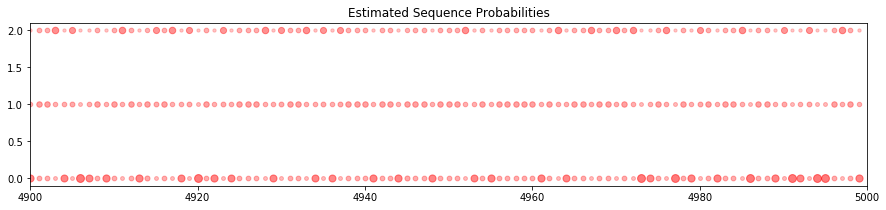

In [19]:
from src.ml.ctw.ctw import CTW

ctw = CTW(depth=2,symbols=3)
pxs = ctw.predict_sequence(x)
plotprobs(pxs,estimate=True,plot_samples=100)

In [12]:
pd.DataFrame(pxs)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.333333,0.266667,0.187075,0.224242,0.180386,0.209145,0.146119,0.290196,0.432634,0.638871,...,0.125628,0.319298,0.376744,0.336323,0.328520,0.317073,0.304029,0.360269,0.301818,0.373219
1,0.333333,0.466667,0.625850,0.442424,0.358898,0.358171,0.306849,0.322549,0.266080,0.170877,...,0.216080,0.298246,0.283721,0.372197,0.509025,0.303136,0.362637,0.481481,0.360000,0.481481
2,0.333333,0.266667,0.187075,0.333333,0.460716,0.432684,0.547032,0.387255,0.301286,0.190252,...,0.658291,0.382456,0.339535,0.291480,0.162455,0.379791,0.333333,0.158249,0.338182,0.145299


We can see that by the end of the when using the correct tree, with access to side information, the probability assignments match the true probabilities.

In [13]:
def load_users_tags_sequence():
    with open('outputs/users_tags_sequence.json') as json_file:
        return json.load(json_file)
    
users_tags_sequence = load_users_tags_sequence()

In [14]:
categ_mapper = CategoryMapper()

In [15]:
def clean_sequence(sequence):
    new_sequence = []
    
    for tags in sequence:
        if "parking" in tags:
            continue
        else:
            new_sequence.append(tags)

    return new_sequence

In [16]:
tags = clean_sequence(users_tags_sequence["6079"])
use_tags = []

for tag in tags:
    if tag == ["WORK"] or tag == ["HOME"]:
        use_tags.append(tag)
        
    else:
        try:
            categ = categ_mapper.map_categ(tag, method="most_specific")
            use_tags.append(categ)

        except NotValidTypes:
            use_tags.append('')

        except NoCategoryMatched:
            use_tags.append("NoCategoryMatched") 

In [17]:
print(len(set(use_tags)))
pd.Series(use_tags).value_counts()

20


restaurant                118
store                      42
health                     35
NoCategoryMatched          28
school                     18
place_of_worship           12
transit_station            12
beauty_salon               10
finance                     9
lodging                     9
hair_care                   8
cafe                        8
bar                         8
political                   4
general_contractor          4
grocery_or_supermarket      3
travel_agency               3
real_estate_agency          2
lawyer                      2
supermarket                 1
dtype: int64

In [18]:
ctw = CTW(depth=4,symbols=len(set(use_tags)))
pxs = ctw.predict_sequence(use_tags)
#plotprobs(pxs,estimate=True,plot_samples=100)

KeyError: "['restaurant', 'cafe', 'restaurant', 'NoCategoryMatched']"

## 3. Sequential Probability Assignment with Depth-3 CTW (w/ side info)

Next we will create sequential probability assignments from a depth-3 context tree. While (slightly) less efficient, we would hope that the probability assignments would be equally good after enough samples.

In [ ]:
ctw = CTW(depth=3,symbols=3,sidesymbols=2)
pxs = ctw.predict_sequence(x,sideseq=y)
plotprobs(pxs,estimate=True,plot_samples=100)

## 4. Sequential Probability Assignment with Depth-1 CTW (w/ side info)
By reducing the depth to make the tree too shallow, we will expect worse performance. In particular, consider the following two contexts from the parameter dictionary:

    '[[0,2],[0,0]]':([1/6,1/6,2/3],[1/2]*2)
    '[[0,2],[0,1]]':([1/3,1/2,1/6],[1/2]*2)
    
Note that they have the same depth-1 context but different depth-2 contexts. Then given that they have different parameter vectors, the predictability of $X_n$ when the depth-1 context is $(0,0)$ is going to be much worse.

In [ ]:
ctw = CTW(depth=1,symbols=3,sidesymbols=2)
pxs = ctw.predict_sequence(x,sideseq=y)
plotprobs(pxs,estimate=True,plot_samples=100)

## 5. Sequential Probability Assignment with Depth-2 CTW (w/o side info)
Similarly to above, if we remove the sideinformation, we can expect a decrease in accuracy from the probability assignments. This "decrease in accuracy" can be used to measure the causal influence of $Y$ on $X$.

In [ ]:
ctw = CTW(depth=2,symbols=3)
pxs = ctw.predict_sequence(x)
plotprobs(pxs,estimate=True,plot_samples=100)

## 6. Sequential Probability Assignment with Depth-4 CTW (w/ 2-stale side info)
Suppose that $X$ and $Y$ are jointly $d$-Markov. Then when including $Y$ as side info when predicting $X$, we only need a tree of depth $d$. In general however, we cannot assume that $X$ is marginally $d$-Markov when leaving out the side info. As such the scenario considered above (example 5) may not be a true representation of how well $X$ can be predicted from its own past. To account for this, we can predict $X$ based on *stale side info*. In this case, we leave out the $k$ most recent samples of side info.

In [ ]:
from ctw import CTW

ctw = CTW(depth=4,symbols=3,sidesymbols=2,staleness=2)
pxs = ctw.predict_sequence(x,y)
plotprobs(pxs,estimate=True,plot_samples=100)